# Graph convolutional network 2D toy models

In this notebook we'll test out some first graph convolutional models on simple toy data.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
cuda = False

In [2]:
# System imports
from __future__ import print_function
from timeit import default_timer as timer

# Externals
import numpy as np
import matplotlib.pyplot as plt

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

%matplotlib notebook

## Data utilties

In [3]:
def gen_tracks(n, det_r):
    """
    Generate n straight tracks.
    
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)
    """
    xin = np.random.uniform(size=n).astype(np.float32)
    xout = np.random.uniform(size=n).astype(np.float32)
    slopes = (xout - xin) / (det_r[-1] - det_r[0])
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def generate_data(n_events, n_tracks, det_r, sort_first_labels=False):
    n_det_layers = det_r.shape[0]

    # Generate all the tracks we'll need
    tracks = np.stack([gen_tracks(n_events, det_r)
                       for i in range(n_tracks)], axis=1)

    idx0 = np.arange(n_events)[:, None, None]
    idx2 = np.arange(n_det_layers)[None, None, :]

    if sort_first_labels:
        # Sort according to the first hit position, so the labels are
        # consistently defined in terms of the first layer hit order.
        # Note: singleton ('None') idx axes indicate a repeat-broadcast.
        idx1 = tracks[:, :, 0].argsort(axis=1)[:, :, None]
        tracks = tracks[[idx0, idx1, idx2]]

    # Now sort all hits on all layers by their position.
    # This sort index relative to previous sort gives us our hit labels.
    idx = np.argsort(tracks, axis=1)
    x = tracks[[idx0, idx, idx2]]

    # Transpose to shape (n_event, n_layer, n_hit)
    return x.transpose([0,2,1]), idx.transpose([0,2,1])

def calc_adjacency(x, r, l, y):
    """Calculate toy data adjacency matrices"""
    # Detector layer adjacency
    adj_l = (np.abs(l[:, None, :] - l[:, :, None]) == 1).astype(np.int)
    # Hit-pair-wise slopes
    dx = x[:, None, :] - x[:, :, None]
    dr = r[:, None, :] - r[:, :, None]
    # Div-by-zero protection
    dr[dr == 0] = 1e-7
    slope = dx / dr
    # Entry and exit points for each slope
    rn = r.max()
    x0 = x[:, None, :] - slope * r[:, None, :]
    xn = x[:, None, :] + slope * (rn - r[:, None, :])
    # Adjacency from entry and exit constraints
    adj_x0 = (x0 < 1) & (x0 > 0)
    adj_xn = (xn < 1) & (xn > 0)
    # Final combined adjacency matrices
    adj = adj_l * adj_x0 * adj_xn
    # True adjacency matrix
    adj_y = (y[:, None, :] == y[:, :, None]) * adj_l
    return adj, adj_y

def norm_adjacency(a):
    """Normalize adjacency so each row sums to 1"""
    d = 1. / a.sum(axis=1)
    anorm = np.zeros_like(a, dtype=np.float32)
    for i in range(a.shape[0]):
        anorm[i] = np.diagflat(d[i]).dot(a[i])
    return anorm

def kwnorm_adjacency(a):
    """Symmetric (+ identity) normalized adjacency"""
    ahat = np.eye(a.shape[1])[np.newaxis] + a
    dval = 1. / np.sqrt(ahat.sum(axis=1))
    anorm = np.zeros_like(a, dtype=np.float32)
    for i in range(a.shape[0]):
        d = np.diagflat(dval[i])
        anorm[i] = d.dot(ahat[i]).dot(d)
    return anorm

In [4]:
# PyTorch memory allocations and conversions
np_to_torch_cpu = lambda x: Variable(torch.from_numpy(x))
np_to_torch_gpu = lambda x: Variable(torch.from_numpy(x)).cuda()
torch_zeros_cpu = lambda *size: Variable(torch.FloatTensor(*size).zero_())
torch_zeros_gpu = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())

np_to_torch = np_to_torch_gpu if cuda else np_to_torch_cpu
torch_zeros = torch_zeros_gpu if cuda else torch_zeros_cpu

## Generate a dataset

In [29]:
# Data config
det_r = np.array([0, 1, 2, 3, 5, 7, 9, 11, 13, 15], dtype=np.float)
n_det_layers = det_r.shape[0]
n_events = 2**16
n_tracks = 4
seed_size = 3

In [30]:
# Hit position and label
hits_x, hits_y = generate_data(n_events, n_tracks, det_r)
# Hit radius
hits_r = np.broadcast_to(det_r[None, :, None], hits_x.shape)
# Layer number
hits_l = np.broadcast_to(np.arange(n_det_layers)[None, :, None], hits_x.shape)
print(hits_x.shape, hits_y.shape)

# Flattened arrays
x, y, r, l = [a.reshape((n_events, -1)) for a in [hits_x, hits_y, hits_r, hits_l]]
print(map(np.shape, [x, y, r, l]))

(65536, 10, 4) (65536, 10, 4)
[(65536, 40), (65536, 40), (65536, 40), (65536, 40)]


## Graph operations
Let's start by constructing a graph convolution module.

In [31]:
def repeat_module(module, x):
    """Applies module on last axis, repeating over others"""
    return module(x.view(-1, x.size(-1))).view(x.size()[:-1] + (-1,))

In [32]:
class GraphConv(nn.Module):
    """
    A minimal graph convolution module.
    
    This module takes an input tensor of node features X and some form
    of adjacency matrix A and applies a linear transformation of the form
        A * X * W + b
    where W and b are weights and biases, respectively.
    """
    
    def __init__(self, input_dim, output_dim):
        super(GraphConv, self).__init__()
        # We implement the patch operator as a linear module
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x, a):
        ax = torch.matmul(a, x)
        return repeat_module(self.linear, ax)

class GraphConvSelfInt(nn.Module):
    """
    A graph convolution module with separate explicit self-interaction terms.
    
    This module takes an input tensor of node features X and adjancency
    matrix A and applies a linear transformation of the form
        X*W1 + A*X*W2 + b
    where (W1, W2) and b are learned weights and biases.
    """
    def __init__(self, input_dim, output_dim):
        super(GraphConvSelfInt, self).__init__()
        self.node_mod = nn.Linear(input_dim, output_dim)
        self.neighbor_mod = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x, a):
        node_term = repeat_module(self.node_mod, x)
        neighbor_term = repeat_module(self.neighbor_mod, torch.matmul(a, x))
        return node_term + neighbor_term

## Binary hit classifier

let's develop a model to assign hits to one track candidate in the event.

In [33]:
class GCNBinaryClassifier(nn.Module):
    """
    A simple graph-convolutional network for binary classification of nodes.
    
    This model applies a feature extractor to each node,
    followed by a number of graph conv layers,
    followed by a node classifier head.
    """
    
    def __init__(self, input_dim, hidden_dims, gc_type=GraphConvSelfInt):
        super(GCNBinaryClassifier, self).__init__()
        # Feature extractor layer
        self.feature_extractor = nn.Linear(input_dim, hidden_dims[0])
        # Graph convolution layers
        n_gc_layers = len(hidden_dims) - 1
        self.gc_layers = nn.ModuleList([gc_type(hidden_dims[i], hidden_dims[i+1])
                                        for i in range(n_gc_layers)])        
        # Node classifier
        self.classifier = nn.Linear(hidden_dims[-1], 1)
    
    def forward(self, x, a):
        # Apply feature extraction layer
        x = F.relu(repeat_module(self.feature_extractor, x))
        # Apply graph conv layers
        for gc in self.gc_layers:
            x = F.relu(gc(x, a))
        # Apply node classifier
        return repeat_module(self.classifier, x).squeeze(-1)

In [34]:
class GCRNBinaryClassifier(nn.Module):
    """
    A graph-convolutional network with residual connections for binary classification of nodes.
    
    This model applies a feature extractor to each node,
    followed by a number of graph conv layers,
    followed by a node classifier head.
    
    The input features are attached to each graph conv layer via residual shortcuts.
    """
    
    def __init__(self, input_dim, hidden_dims, gc_type=GraphConvSelfInt):
        super(GCRNBinaryClassifier, self).__init__()
        # Feature extractor layer
        self.feature_extractor = nn.Linear(input_dim, hidden_dims[0])
        # Graph convolution layers
        n_gc_layers = len(hidden_dims) - 1
        self.gc_layers = nn.ModuleList([gc_type(hidden_dims[i] + input_dim,
                                                hidden_dims[i+1])
                                        for i in range(n_gc_layers)])  
        # Node classifier
        self.classifier = nn.Linear(hidden_dims[-1], 1)
    
    def forward(self, x, a):
        # Apply feature extraction layer
        h = F.relu(repeat_module(self.feature_extractor, x))
        # Apply graph conv layers
        for gc in self.gc_layers:
            # Stack input features onto current node features
            h = torch.cat([h, x], dim=-1)
            h = F.relu(gc(h, a))
        # Apply node classifier
        return repeat_module(self.classifier, h).squeeze(-1)

In [35]:
def predict_prob(model, inputs):
    return F.sigmoid(model(inputs))

def training_step(model, inputs, targets, loss_func, optimizer):
    model.train()
    model.zero_grad()
    outputs = model(*inputs)
    loss = loss_func(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss

def accuracy(probs, target, threshold=0.5):
    return ((probs.data.numpy() > threshold) == (target.data.numpy() > 0.5)).mean()

### Finalize the dataset for training

In [36]:
# Take track label 0 as the target track.
y0 = (y == 0).astype(np.float32)

# Create a binary seed feature which gives the label on first layer
seed = np.zeros_like(y0)
for seed_layer in range(seed_size):
    seed[l==seed_layer] = y0[l==seed_layer]

# Testing the trivial model with solution given
#seed = y0

# Prepare the input tensor
X = np.stack([x, r / r.max(), seed], axis=-1)

# Adjacency matrices for all events
adj, adj_y = calc_adjacency(x, r, l, y)

# Normalized adjacency
A = norm_adjacency(adj)

# Kipf-Welling normalized adjacency
#A = kwnorm_adjacency(adj)

In [37]:
# Model config
n_features = X.shape[-1]
hidden_dims = [8, 32, 32, 32, 32, 32, 32, 16, 16, 8]

# Training config
batch_size = 32
n_epochs = 10
test_frac = 0.1

In [38]:
n_train = int(n_events * (1 - test_frac))
n_batches = (n_train + batch_size - 1) // batch_size

# Split data into train and test sets
train_X = np_to_torch(X[:n_train].astype(np.float32))
train_A = np_to_torch(A[:n_train].astype(np.float32))
train_y = np_to_torch(y0[:n_train].astype(np.float32))
test_X = np_to_torch(X[n_train:].astype(np.float32))
test_A = np_to_torch(A[n_train:].astype(np.float32))
test_y = np_to_torch(y0[n_train:].astype(np.float32))

print('Training samples:', n_train)
print('Batches per epoch:', n_batches)
print('Test samples:', n_events - n_train)

Training samples: 58982
Batches per epoch: 1844
Test samples: 6554


In [39]:
# Construct the model
model = GCRNBinaryClassifier(n_features, hidden_dims)
#model = GCNBinaryClassifier(n_features, hidden_dims)
if cuda: model.cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()
print(model)
print('Parameters:', sum(param.numel() for param in model.parameters()))

GCRNBinaryClassifier (
  (feature_extractor): Linear (3 -> 8)
  (gc_layers): ModuleList (
    (0): GraphConvSelfInt (
      (node_mod): Linear (11 -> 32)
      (neighbor_mod): Linear (11 -> 32)
    )
    (1): GraphConvSelfInt (
      (node_mod): Linear (35 -> 32)
      (neighbor_mod): Linear (35 -> 32)
    )
    (2): GraphConvSelfInt (
      (node_mod): Linear (35 -> 32)
      (neighbor_mod): Linear (35 -> 32)
    )
    (3): GraphConvSelfInt (
      (node_mod): Linear (35 -> 32)
      (neighbor_mod): Linear (35 -> 32)
    )
    (4): GraphConvSelfInt (
      (node_mod): Linear (35 -> 32)
      (neighbor_mod): Linear (35 -> 32)
    )
    (5): GraphConvSelfInt (
      (node_mod): Linear (35 -> 32)
      (neighbor_mod): Linear (35 -> 32)
    )
    (6): GraphConvSelfInt (
      (node_mod): Linear (35 -> 16)
      (neighbor_mod): Linear (35 -> 16)
    )
    (7): GraphConvSelfInt (
      (node_mod): Linear (19 -> 16)
      (neighbor_mod): Linear (19 -> 16)
    )
    (8): GraphConvSelfInt (
  

In [40]:
batch_idxs = np.arange(0, n_train, batch_size)
train_losses, test_losses = [], []

for i in range(n_epochs):
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    for j in batch_idxs:
        batch_X = train_X[j:j+batch_size]
        batch_A = train_A[j:j+batch_size]
        batch_inputs = [batch_X, batch_A]
        batch_y = train_y[j:j+batch_size]
        sum_loss += training_step(model, batch_inputs, batch_y, loss_func, optimizer)

    end_time = timer()
    avg_loss = sum_loss.cpu().data[0] / n_batches
    train_losses.append(avg_loss)
    print('  training loss %.3g' % avg_loss, 'time %gs' % (end_time - start_time))
    
    # Evaluate the model on the test set
    model.eval()
    test_output = model(test_X, test_A)
    test_loss = loss_func(test_output, test_y).cpu().data[0]
    test_losses.append(test_loss)
    print('  test loss %.3g' % test_loss)

Epoch 0
  training loss 0.281 time 32.4754s
  test loss 0.237
Epoch 1
  training loss 0.229 time 32.7454s
  test loss 0.22
Epoch 2
  training loss 0.219 time 32.6591s
  test loss 0.212
Epoch 3
  training loss 0.211 time 32.2646s
  test loss 0.206
Epoch 4
  training loss 0.205 time 32.3641s
  test loss 0.201
Epoch 5
  training loss 0.201 time 31.4773s
  test loss 0.201
Epoch 6
  training loss 0.198 time 31.8418s
  test loss 0.198
Epoch 7
  training loss 0.197 time 32.7237s
  test loss 0.215
Epoch 8
  training loss 0.198 time 32.9745s
  test loss 0.193
Epoch 9
  training loss 0.193 time 34.1669s
  test loss 0.19


In [42]:
# Evaluate accuracy on the test set
test_probs = F.sigmoid(test_output)

In [43]:
accuracy(test_probs, test_y, threshold=0.5)

0.89689884040280743

In [44]:
# Use the input seed feature as the classifier
accuracy(test_X[:, :, 2], test_y)

0.82499999999999996

<IPython.core.display.Javascript object>


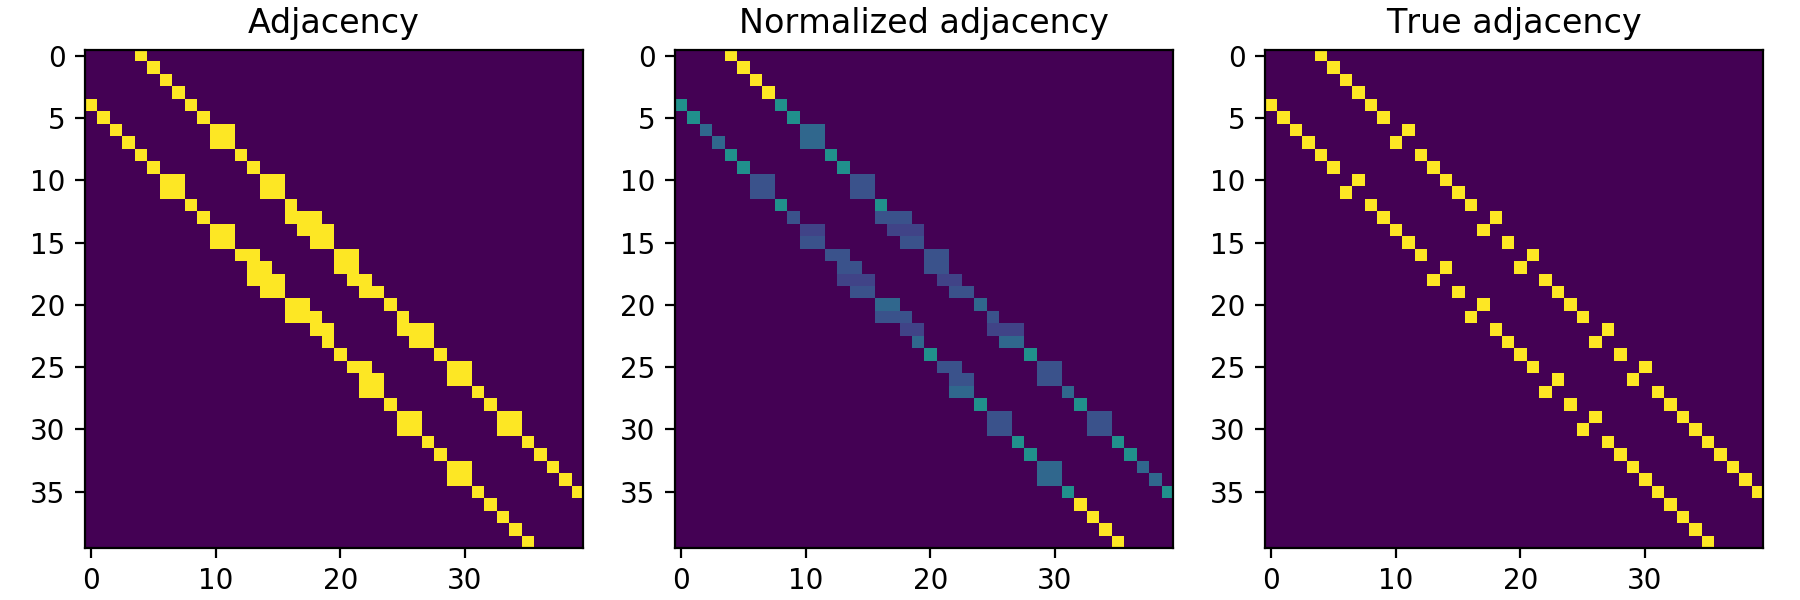

<IPython.core.display.Javascript object>


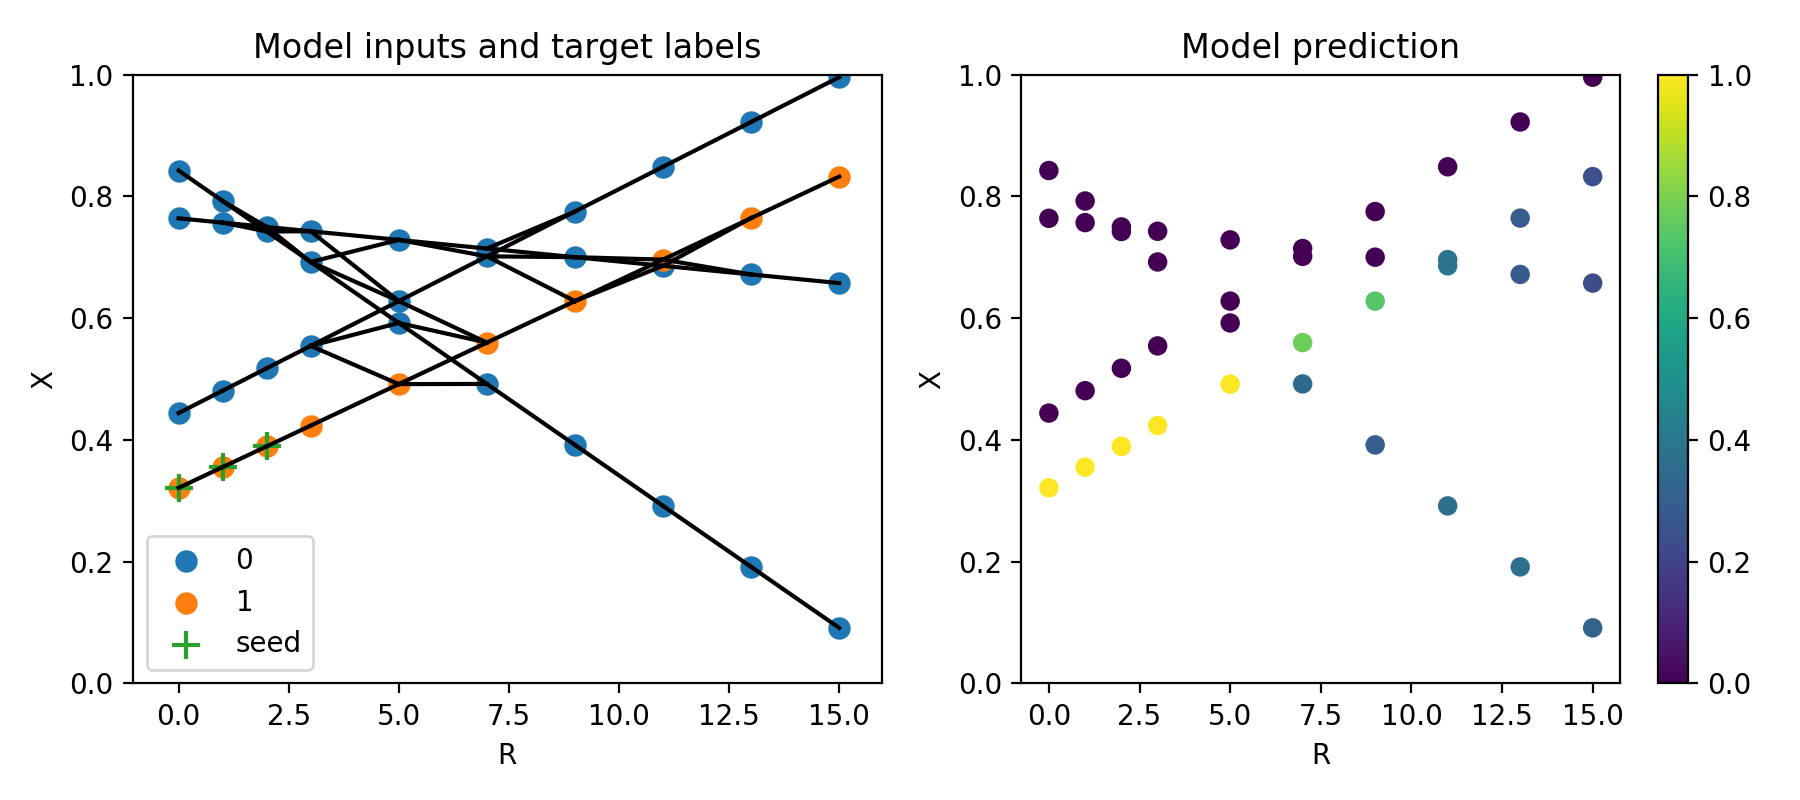

In [50]:
# Choose an event
i = 5

sample_X = train_X[i:i+1]
sample_A = train_A[i:i+1]
sample_y = train_y[i:i+1]
sample_logits = model(sample_X, sample_A)
sample_probs = F.sigmoid(sample_logits)

# Draw the adjacency matrices for this sample
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(adj[i])
plt.title('Adjacency')
plt.subplot(132)
plt.imshow(A[i])
plt.title('Normalized adjacency')
plt.subplot(133)
plt.imshow(adj_y[i])
plt.title('True adjacency')
plt.tight_layout()

plt.figure(figsize=(9,4))

# Draw the inputs
plt.subplot(121)

# Draw all segments in the adjacency matrix
for j in range(x.shape[1]):
    for k in range(j + 1, x.shape[1]):
        if adj[i,j,k] > 0:
            plt.plot([r[i, j], r[i, k]], [x[i, j], x[i, k]], 'k-', alpha=adj[i,j,k])

# Draw the labeled hits
for label in np.unique(y0[i].astype(int)):
    plt.scatter(r[i][y0[i]==label], x[i][y0[i]==label], s=50, label=label)

# Mark the seed hits
seed_idx = seed[i].astype(bool)
plt.scatter(r[i][seed_idx], x[i][seed_idx], marker='+', s=100, label='seed')

plt.title('Model inputs and target labels')
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
plt.legend(loc=0)

# Draw the model prediction
plt.subplot(122)
# Use the predicted probabilities as the color scale
c = sample_probs.cpu().data.numpy()
plt.scatter(r[i], x[i], c=c)
plt.colorbar()

plt.title('Model prediction')
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')

plt.tight_layout()

## Discussion

The model is not yet performing well. I suspect the adjacency averaging over the neighboring nodes is too destructive for good information flow. It's probably a problem that my adjacency matrix is binary and thus doesn't capture any information relevant to selecting the correct hits.

Things I've already tried
- Kipf + Welling symmetric normalization of adjacency matrix
- feature extraction module applied to input
- split off the node self interactions into their own terms
- shortcut the input features to each graph-conv layer (like residual connections)

Some things yet to try:
- split input and output connections into separate terms (two adjacency matrices)
- add another adjacency matrix for neighboring hits on same layer.
- add a graph attention mechanism which determines how to weight each neighbor.